# TGFB1 Part 1 - Importing the data

In this notebook, we take the data from the matrix, gene and cell files and create an AnnData matrix we can use for future analyses.

In [ ]:
import numpy as np
import pandas
import scanpy
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/tgfb1-1.h5ad'  # the file that will store the analysis results

# Load the sparse transcript count matrix

The count matrix is of the format:

    %
    no_genes no_cells no_counts
    19 1 1
    34 1 1
    [...]
    33663 12318 1
    33665 12318 35
    33678 12318 1

where the first number represents the gene, the second number represents the cell, and the third number represents the count.

First, we will load the data into a matrix called ``matrix``, accessing the count as ``matrix[gene][cell]``.
    

In [2]:
matrix = None

with open("matrix.mtx", "r") as f:
    first_line = True
    
    for line in f:
        if "%" in line:
            continue
        
        line = [int(i) for i in line.rstrip().split()]
        
        if first_line:
            genes, cells, count = line
            first_line = False
            matrix = np.ndarray(shape=(genes,cells))
        else:
            genes, cells, count = line
            matrix[genes-1, cells-1] = count

In [3]:
matrix.shape

(33694, 12318)

Note, we first index by genes (33694), and then by cells (12318)

# Load batch labels

Load batch barcode data. It is of the format:

    AAACCTGAGACATAAC-1

where ``AAACCTGAGACATAAC`` is a nucleotide barcode and ``1`` is the batch it corresponds to. Load it into a Python list of lists accessed as e.g. `batches[batch][5]`, where `batch` is the batch number minus one, and `5` is the fifth barcode for that batch in the list.

In [4]:
with open("barcodes.tsv") as f:
    batches = [[], []]
    batch_per_cell = []
    
    for i, line in enumerate(f):
        
        barcode, batch = line.rstrip("\n").split("-")
        batch = int(batch) - 1
        batches[batch].append(i)
        batch_per_cell.append(batch + 1)

As expected, the last batch label is 12317, one less than the number of cells

In [5]:
batches[1][-1]

12317

# Load gene ids

Load a dictionary mapping gene IDs to gene names, such as:
    
    ENSG00000277630 BX072566.1
    ENSG00000278384 AL354822.1

For example, `genes[1] = ("ENSG00000278384", "AL354822.1")`. To get all gene IDs, use `genes.keys()` and to get all gene names, use `genes.values()`.


In [6]:
genes = []

with open("genes.tsv") as f:
    for id_gene in f:
        
        gene_id, gene_name = id_gene.split()
        genes.append((gene_id, gene_name))

As expected, the number of genes is equal to the number of genes.

In [7]:
len(genes)

33694

# Check if there is a significant coverage disparity between batches

In [8]:
batch_1 = matrix[:,batches[0]]

In [9]:
batch_2 = matrix[:,batches[1]]

In [10]:
cell_count_1 = batch_1.sum(0)

In [11]:
cell_count_2 = batch_2.sum(0)

This is the number of cells in the first batch

In [12]:
len(cell_count_1)

5245

This is the number of cells in the second batch

In [13]:
len(cell_count_2)

7073

# Scale histograms by the number of cells

In [14]:
len(cell_count_1)//50

104

In [15]:
len(cell_count_2)//50

141

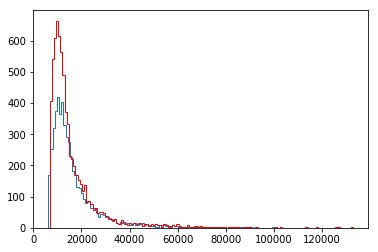

In [16]:
plt.hist(cell_count_1, bins=len(cell_count_1)//50, histtype='step')
plt.hist(cell_count_2, bins=len(cell_count_2)//50, histtype='step', color="r")
pass

# Underscale the first batch

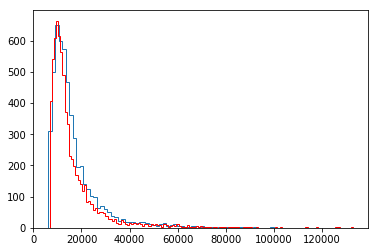

In [17]:
plt.hist(cell_count_1, bins=len(cell_count_1)//80, histtype='step')
plt.hist(cell_count_2, bins=len(cell_count_2)//50, histtype='step', color="r")
pass

# Let's convert our data into scanpy format

Our `matrix` will now be transposed, that is, it will be accessed as `matrix[cell][gene]`.

In [18]:
matrix = matrix.T

In [19]:
matrix.shape

(12318, 33694)

In [20]:
gene_annotation = pandas.DataFrame({"gene_names": [gene[0] for gene in genes], "gene_ids": [gene[1] for gene in genes]})

In [21]:
gene_annotation.shape

(33694, 2)

In [22]:
batch_annotation = pandas.DataFrame({"batch": batch_per_cell})

In [23]:
batch_annotation.shape

(12318, 1)

In [24]:
matrix = anndata.AnnData(X=matrix, obs=batch_annotation, var=gene_annotation)

In [25]:
matrix

AnnData object with n_obs × n_vars = 12318 × 33694 
    obs: 'batch'
    var: 'gene_names', 'gene_ids'

# Running scanpy analysis

In [26]:
matrix.var_names = [gene[1] for gene in genes]
matrix.var_names_make_unique()
matrix.obs_names = [str(batch) for batch in batch_per_cell]
matrix.obs_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


# Save imported matrix

In [27]:
matrix.write(results_file)

... storing 'gene_ids' as categorical
